<a href="https://colab.research.google.com/github/knaat/Ames-housing/blob/main/possible_solutions_ames_housing_expanded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# we want to use sklearn >= 0.23 for visualizing pipelines
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


# Ames Housing case - examples of possible solutions + some added feature engineering


## Objective
There are many ways to skin a cat, so there isn't one 'silver bullit' solution to the Ames Housing case. This notebook provides possible solutions with the following in mind:

* Solutions how to do the various steps of the data mining process in clean and compact code, using `sklearn` and `pandas` as much as possible
* KISS principle: see how we can build the best prediction with the least amount of variables

In [3]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.utils import estimator_html_repr
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# check version
print(f"using scikit-learn version {sklearn.__version__}")

# setting to visualize pipelines
# see https://towardsdatascience.com/are-you-using-pipeline-in-scikit-learn-ac4cd85cb27f
sklearn.set_config(display='diagram')

# seaborn theme
sns.set_style('whitegrid')

# dataset
URL = 'https://github.com/jads-nl/discover-projects/blob/main/ames-housing/AmesHousing.csv?raw=true'

# leaderboard to compare our results
LEADERBOARD = 'https://github.com/jads-nl/discover-projects/blob/main/ames-housing/house-prices-advanced-regression-techniques-publicleaderboard.csv?raw=true'

# fill-value for missings in categorical variables
MISSING = 'missing'
NONE = 'not present'

using scikit-learn version 0.23.2


# Data understanding

### Exploratory data analysis (EDA)

For an elaborate EDA, please refer to [Pedro Marcelino's notebook on Kaggle](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python). We will cut the chase and just follow-up on the recommendations by the author of the dataset:
  - Remove all homes with a living area (GR LIVE AREA) above 4000 square feet
  - NAs means 'not presents' for the categorical variables `Alley`, `Bsmt Qual`, `Bsmt Cond`, `BsmtFin Type 1`, `BsmtFin Type 2`, `Fireplace Qu`,
`Garage Type`, `Garage Finish`, `Garage Qual`, `GarageCond`, `Pool QC` `Fence`, `Garage Yr Blt` and `Misc Feature`

To get started we use `pandas.read_csv`. Note that you can directly fetch a file from internet (without having to download it locally). This makes it easy for sharing on online Jupyter environments like Colab.

In [4]:
df = pd.read_csv(URL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [5]:
# use fillna for all columns where na means none
cols_na_means_none = ['Alley',
                 'Bsmt Qual',
                 'Bsmt Cond',
                 'BsmtFin Type 1',
                 'BsmtFin Type 2',
                 'Fireplace Qu',
                 'Garage Type',
                 'Garage Finish',
                 'Garage Qual',
                 'Garage Cond',
                 'Pool QC',
                 'Fence',
                 'Garage Yr Blt',
                 'Misc Feature']

df.loc[:, cols_na_means_none] = df.loc[:, cols_na_means_none].fillna(value=NONE)

In [6]:
# see which columns have NAs, you could make this into a small utility function
def na_per_columns(df):
    """Calculates nulls per column
    """
    nulls = df.isnull().sum()
    return nulls[nulls != 0].sort_values(ascending=False)


cols_with_nulls = na_per_columns(df)
cols_with_nulls

Lot Frontage      490
Bsmt Exposure      83
Mas Vnr Area       23
Mas Vnr Type       23
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Area         1
Garage Cars         1
Electrical          1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
BsmtFin SF 1        1
dtype: int64

Changed plot to show anomalous sales with > 4000 sq feet living area and spread of Sale Condition types.  Removal of non-Normal sales is included in feature engineering section below.    

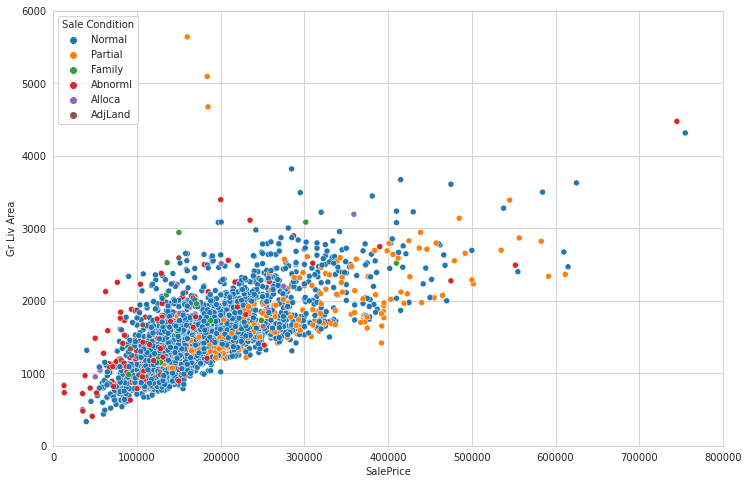

In [7]:
# check if outliers Gr Liv Area > 4000 and visualise Sale Condition
plt.figure(figsize=(12,8))
plt.xlim(0, 800000)
plt.ylim(0, 6000)
sns.scatterplot(data=df, x='SalePrice', y='Gr Liv Area', hue='Sale Condition');

In [8]:
# Removing 5 outliers as per description Ames Housing dataset
df.drop(df[df['Gr Liv Area'] >= 4000].index, inplace=True)
df.shape

(2925, 82)

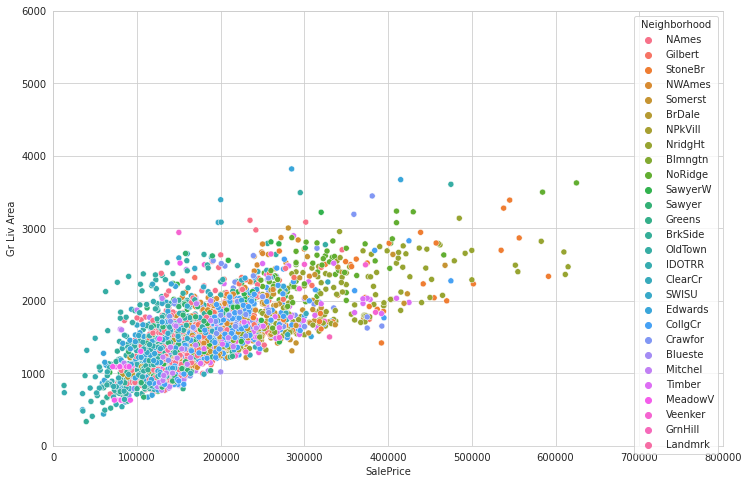

In [9]:
# check if outliers Gr Liv Area > 4000 have been removed and visualise spread of neighborhoods as illustration 
plt.figure(figsize=(12,8))
plt.xlim(0, 800000)
plt.ylim(0, 6000)
sns.scatterplot(data=df, x='SalePrice', y='Gr Liv Area', hue='Neighborhood');

### Optimizing memory usage

Use `df.info()` to get a first view. In this case the dataset is not so large (1.8 MB). If anything gets beyond hundreds of MBs in memory, it helps to optimize, by using [`pd.to_numeric(downcast=...)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html?highlight=to_numeric#pandas.to_numeric) and converting categorical variables to [`pd.categorical`](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html). Doing so reduces the memory to 22% of the orginal (400 KB). 

In [10]:
# objects to categorical
df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').astype('category')

# convert integers to smallest unsigned integer and floats to smallest
for old, new in [('integer', 'unsigned'), ('float', 'float')]:
    for col in df.select_dtypes(include=old).columns:
        df[col] = pd.to_numeric(df[col], downcast=new)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Order            2925 non-null   uint16  
 1   PID              2925 non-null   uint32  
 2   MS SubClass      2925 non-null   uint8   
 3   MS Zoning        2925 non-null   category
 4   Lot Frontage     2435 non-null   float32 
 5   Lot Area         2925 non-null   uint32  
 6   Street           2925 non-null   category
 7   Alley            2925 non-null   category
 8   Lot Shape        2925 non-null   category
 9   Land Contour     2925 non-null   category
 10  Utilities        2925 non-null   category
 11  Lot Config       2925 non-null   category
 12  Land Slope       2925 non-null   category
 13  Neighborhood     2925 non-null   category
 14  Condition 1      2925 non-null   category
 15  Condition 2      2925 non-null   category
 16  Bldg Type        2925 non-null   category


N.B. Split test and train datasets with test_size=0.5 to compare apples to apples with Kaggle competition where train and test datasets are 50-50 split. Set a random_state=42 to ensure results are the same for each run. 

In [11]:
#
# No data snooping 
#
# N.B. Select test_size=0.5 to compare apples to apples with Kaggle competition where train and test datasets
# are 50-50 split. With a larger subset in principle a better model can be dreived. 
#
# Set a random_state to ensure results are the same for each run. 
#
df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

In [12]:
# evaluate which columns have large percentage missing values, say 20%
cols_to_drop = (cols_with_nulls[cols_with_nulls / len(df) > 0.2] / len(df)).index
cols_with_nulls[cols_to_drop]

Series([], dtype: int64)

## Data preparation

So we are going to:

- Create different regression models for the logarithm of the `SalePrice`
- Drop columns with more than 20% missing values
- Impute missing values using [`sklearn.impute.SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)
  - 'median' for numerical features
  - fill with 'missing' for categorical features
- use [`OneHotEncoding`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) for all categorical variables
- use [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) on numerical variables just to be sure.

We are going to use [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for our whole workflow. It is good practice to structure your ML project into separate pipelines for each model. This also allows for stacking models, as is explained in [this example by Guillaume Lemaitre in the sklearn documentation](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py).


### Selecting columns by [`dtype`](https://numpy.org/doc/stable/reference/arrays.scalars.html) with [`df.select_dtypes`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html?highlight=select_dtype)

In [13]:
# prepare X and y, using log(SalePrice) throughout
X = df_train[df_train.columns.difference(cols_to_drop).drop('SalePrice')]
y = np.log(df_train['SalePrice'])

# same for test set
X_test = df_test[df_test.columns.difference(cols_to_drop).drop('SalePrice')]
y_test = np.log(df_test['SalePrice'])

# read https://numpy.org/doc/stable/reference/arrays.scalars.html
# for understanding NumPy dtype hierarchy
cat_cols = X.select_dtypes(include='category').columns
num_cols = X.select_dtypes(include='number').columns

### Making a pipeline

If you want to read more about pipelines, see [this blogpost by Ankit Goel](https://towardsdatascience.com/are-you-using-pipeline-in-scikit-learn-ac4cd85cb27f).

If you have used `category` dtypes from the start, you can access the categories of each categorical column with [`pd.Series.cat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.html?highlight=cat#pandas.Series.cat).

In [14]:
# need to explicitly define categories for pipeline
for col in cat_cols:
    # need to add category for missings, otherwise error with OneHotEncoding
    X[col].cat.add_categories(MISSING, inplace=True)
categories = [X[col].cat.categories for col in cat_cols]

# combine all preprocessing for cat_cols in one pipeline
preprocess_cat_cols = make_pipeline(
    SimpleImputer(
        missing_values = np.nan,
        strategy='constant',
        fill_value=MISSING),
    OneHotEncoder(categories=categories)
)

# same for num_cols
preprocess_num_cols = make_pipeline(
    SimpleImputer(
        missing_values=np.nan,
        strategy='median'
        ),
    StandardScaler()
)

# compose dataset with make_column_transformer
prepare_linear = make_column_transformer(
    (preprocess_num_cols, num_cols),
    (preprocess_cat_cols, cat_cols),
    remainder='drop'
)

## Linear models
 

### [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [15]:
ols = make_pipeline(
    prepare_linear,
    LinearRegression()
    )

ols_score = cross_validate(
    ols, X, y,
    cv=10,
    scoring=['neg_mean_squared_error'],
    return_train_score=True,
    return_estimator=True,
)

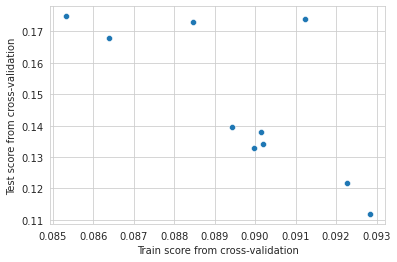

In [16]:
ols_ax = sns.scatterplot(
    x=np.sqrt(-ols_score['train_neg_mean_squared_error']),
    y=np.sqrt(-ols_score['test_neg_mean_squared_error']),
)
ols_ax.set(
    xlabel='Train score from cross-validation',
    ylabel='Test score from cross-validation',
)
plt.show()

We can conclude from this that we need more work: a low RMSLE on the training set results in the highest RMSLE for the validation set (and vice versa). This could mean we are overfitting. 

Or is it maybe related to the remaining outliers in the dataset? If the cross-validation samples such that most outliers are in the cross-validation train dataset then the validation test results are probably going to be better and vice versa.

The best model for now is in the bottom right corner, with a test RMSLE of around 0.11. Let's check which estimator that is and do final scoring on test set.

In [17]:
#
# use np.argmax to find bottomright point == largest RMLSE on train and smallest on test from cross-validation, 
# but maybe not on X_test, y_test !
#
ols_best_index = np.argmax(np.sqrt(-ols_score['train_neg_mean_squared_error']))
ols_best = ols_score['estimator'][ols_best_index]
ols_best_rmsle = np.sqrt(mean_squared_error(y_test, ols_best.predict(X_test)))
print(f"Best OLS model based on CV scores:  RMLSE: {ols_best_rmsle:0.5f}")

Best OLS model based on CV scores:  RMLSE: 0.13522


There might be a better model when evaluating score of y_test 

In [18]:
#
# Look for better y_test score in 10 CV models 
#
best_score = ols_best_rmsle

for icount in range(0,10):
    ols_best = ols_score['estimator'][icount]
    ols_best_rmsle = np.sqrt(mean_squared_error(y_test, ols_best.predict(X_test)))
    if ols_best_rmsle < best_score:
        best_score = ols_best_rmsle
        best_model_index = icount
              
print(f"Best OLS model found index={best_model_index} =>  RMLSE: {best_score:0.5f}\n")

Best OLS model found index=1 =>  RMLSE: 0.12951



Best simple regression model with preparing the data just as the author instructed with no further feature engineering yields a RMSLE of 1.2951. Let's see where that gets us on the leaderboard.

In [19]:
leaderboard = pd.read_csv(LEADERBOARD).sort_values('Score').reset_index()
leaderboard.Score.searchsorted(best_score)

1607

Decent start. We are around 1607th place out of more that 5,000 entries. Up next: Some selective extra feature engineering to get to a better position. 

# Linear models with some selective feature engineering
 

#### Selection of feature engineering steps by switching Booleans
1. Deletion of irrelevant columns 'Order' and 'PID' 
2. Log transform of all numeric features with skew > 0.75 (excluding SalePrice which gets transformed later)
3. Some additional feature engineering combining and creating features. Limited impact with Linear Regression but might be useful with Lasso or other models.   Other combinations of e.g. Gr Liv Area with Basement size could also be tried.
4. Removal of abnormal sales from training dataset to test if a better model can be derived.
5. Only keep Normal sales in training dataset to test if a better model can be derived.  

In [20]:
#
# Select which feature engineering steps you would like to apply. Make sure to re-read the csv data when making changes to avoid error messages
#
del_cols = True
log_transform = True
add_location_feature = True
# Choose one or none of the steps below
remove_abnorml_sales = False
keep_normal_sales = True

# Read data again to start from beginning
df = pd.read_csv(URL)

# Remove 5 outliers as per description Ames Housing dataset
df.drop(df[df['Gr Liv Area'] >= 4000].index, inplace=True)

# use fillna for all columns where na means none
cols_na_means_none = ['Alley',
                 'Bsmt Qual',
                 'Bsmt Cond',
                 'BsmtFin Type 1',
                 'BsmtFin Type 2',
                 'Fireplace Qu',
                 'Garage Type',
                 'Garage Finish',
                 'Garage Qual',
                 'Garage Cond',
                 'Pool QC',
                 'Fence',
                 'Garage Yr Blt',
                 'Misc Feature']

df.loc[:, cols_na_means_none] = df.loc[:, cols_na_means_none].fillna(value=NONE)


In [21]:
#
# 1. Delete some irrelevant columns 
#
if del_cols:
    # Drop columns irrelevant 'Order' and 'PID' columns
    df.drop(columns=['Order', 'PID'], inplace=True)
    print(f"Dropping columns 'Order' and 'PID'")

Dropping columns 'Order' and 'PID'


In [22]:
#
# 2. log transform of features with skew > 0.75. This include SalePrice (no need to transform again later).
#

if log_transform:
    # Determine numeric columns
    num_cols = df.select_dtypes(include='number').columns

    # Calculate skew for each numeric feature and select features with skew>0.75 
    calc_skew_col = df[num_cols].skew()
    skew_cols = list(calc_skew_col[calc_skew_col > 0.75].index)

    # Remove SalePrice from the skew_cols list as it will be log-trasnformed separately
    skew_cols.remove('SalePrice')

    print(f"Log transforming following features: {skew_cols}")
    for column in skew_cols:
        df.loc[:,column] = np.log(df[column]+0.00000001)

Log transforming following features: ['MS SubClass', 'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Half Bath', 'Kitchen AbvGr', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']


In [23]:
#
# 3. Some additional feature engineering combining and creating features based on analysis in example notebooks: 
#    https://github.com/at-tan/Ames_housing_OLS/blob/master/Ames_housing_I.ipynb
#    https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5
#
#   Other combinations of e.g. Gr Liv Area with Basement size could also be tried.
#
if add_location_feature:
     print(f"Combining/creating features")
     def add_location(x):
        if 'MeadowV' in x or 'Edwards' in x or 'Sawyer' in x or 'IDOTRR' in x or 'Brkside' in x or 'BrDale' in x:
            return 1
        elif 'Swisu' in x or 'Mitchel' in x or 'NAmes' in x or 'NPkVill' in x or 'ClearCr' in x or 'OldTown' in x or 'SawyerW' in x:
            return 2
        elif 'Gilbert' in x or 'NWAmes' in x or 'Blueste' in x or 'CollgCr' in x or 'Timber' in x or 'Crawfor' in x:
            return 3
        else:
            return 4
     df['Location'] = df.Neighborhood.map(add_location)  

     df['TotalBathrooms'] = df['Bsmt Half Bath'] + df['Bsmt Full Bath'] + df['Half Bath'] + df['Full Bath']
     columns = ['Bsmt Half Bath', 'Bsmt Full Bath', 'Half Bath', 'Full Bath']
     df.drop(columns, axis=1, inplace=True)

     df['Remod_Diff'] = df['Year Remod/Add'] - df['Year Built']
     df.drop('Year Remod/Add', axis=1, inplace=True)

     df['TotalPorchSF'] = df['Open Porch SF'] + df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch'] 
     def PorchFlag(col):
       if col['TotalPorchSF'] == 0:
         return 1
       else:
        return 0
     df['NoPorch_Flag'] = df.apply(PorchFlag, axis=1)

     def PoolFlag(col):
       if col['Pool Area'] == 0:
         return 0
       else:
         return 1
    
     df['HasPool_Flag'] = df.apply(PoolFlag, axis=1)
     


Combining/creating features


In [24]:
# objects to categorical
df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').astype('category')

N.B. Split test and train datasets with test_size=0.5 to compare apples to apples with Kaggle competition where train and test datasets are 50-50 split. Set a random_state=42 to ensure results are the same for each run.

In [25]:
# no data snooping N.B. Select test_size=0.5 to compare apples to apples with Kaggle competition where train and test datasets
# are 50-50 split. Set a random_state to ensure results are the same for each run. 
df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

In [26]:
#
# 4. Remove abnormal sales from data_train dataframe. So determine model on dataset without these sales but do not remove from test
#

if remove_abnorml_sales:
    # Remove all Sales with Sale Condition = 'Abnorml' 
    before_shape = df_train.shape[0] 
    df_train.drop(df_train[df_train['Sale Condition'] == 'Abnorml'].index, inplace=True)
    print(f"\nRemoved {before_shape-df_train.shape[0]} rows with 'Abnorml' Sale Condition from training dataset\n")

In [27]:
#
# 5. Only select normal sales for data_train dataframe. So determine model on dataset without other sales but do not remove from test
#

if keep_normal_sales:
    # Remove all Sales with Sale Condition =  
    before_shape = df_train.shape[0] 
    df_train.drop(df_train[df_train['Sale Condition'] != 'Normal'  ].index, inplace=True)
    print(f"\nRemoved {before_shape-df_train.shape[0]} rows with Non-'Normal' Sale Condition from training dataset\n")


Removed 257 rows with Non-'Normal' Sale Condition from training dataset



/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
# prepare X and y, using log(SalePrice) throughout
X = df_train[df_train.columns.difference(cols_to_drop).drop('SalePrice')]
y = np.log(df_train['SalePrice'])

# same for test set
X_test = df_test.drop(columns=['SalePrice'])
y_test = np.log(df_test['SalePrice'])

# read https://numpy.org/doc/stable/reference/arrays.scalars.html
# for understanding NumPy dtype hierarchy
cat_cols = X.select_dtypes(include='category').columns
num_cols = X.select_dtypes(include='number').columns

### Making a pipeline

If you want to read more about pipelines, see [this blogpost by Ankit Goel](https://towardsdatascience.com/are-you-using-pipeline-in-scikit-learn-ac4cd85cb27f).

If you have used `category` dtypes from the start, you can access the categories of each categorical column with [`pd.Series.cat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.html?highlight=cat#pandas.Series.cat).

In [29]:
# need to explicitly define categories for pipeline
for col in cat_cols:
    # need to add category for missings, otherwise error with OneHotEncoding
    X[col].cat.add_categories(MISSING, inplace=True)
categories = [X[col].cat.categories for col in cat_cols]

# combine all preprocessing for cat_cols in one pipeline
preprocess_cat_cols = make_pipeline(
    SimpleImputer(
        missing_values = np.nan,
        strategy='constant',
        fill_value=MISSING),
    OneHotEncoder(categories=categories)
)

# same for num_cols
preprocess_num_cols = make_pipeline(
    SimpleImputer(
        missing_values=np.nan,
        strategy='median'
        ),
    StandardScaler()
)

# compose dataset with make_column_transformer
prepare_linear = make_column_transformer(
    (preprocess_num_cols, num_cols),
    (preprocess_cat_cols, cat_cols),
    remainder='drop'
)

In [30]:
ols = make_pipeline(
    prepare_linear,
    LinearRegression()
    )
ols_score = cross_validate(
    ols, X, y,
    cv=10,
    scoring=['neg_mean_squared_error'],
    return_train_score=True,
    return_estimator=True,
)

In [31]:
# Look for best X_test y_test score in 10 CV models 
best_score = 999

for icount in range(0,10):
    ols_best = ols_score['estimator'][icount]
    ols_best_rmsle = np.sqrt(mean_squared_error(y_test, ols_best.predict(X_test)))
    if ols_best_rmsle < best_score:
        best_score = ols_best_rmsle
        best_model_index = icount

print(f"\n Best OLS model found index={best_model_index} =>  RMLSE: {best_score:0.5f}\n")

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transform


 Best OLS model found index=3 =>  RMLSE: 0.11558



## Results

The 5 different feature engineering steps result in the following improved RMSLE. 

No additional feature engineering:  RMSLE 0.12951.  
1. Deletion of irrelevant columns 'Order' and 'PID'.  RMSLE 0.13033  Surprising to see the score deteriorate. 
2. Log transform of all numeric features with skew > 0.75 (excluding SalePrice which gets transformed later) RMSLE 0.12341. Clear improvement. 
3. Some additional feature engineering combining and creating features. RMSLE 0.12862. Limited impact with Linear Regression but might be useful with Lasso or other models. Other combinations of e.g. Gr Liv Area with Basement size could also be tried. 
4. Removal of abnormal sales from training dataset to test if a better model can be derived. RMSLE 0.12697. Small step forward. Possibly related to removed outliers.
5. Only keep Normal sales in training dataset to test if a better model can be derived. RMSLE 0.12358. Additional improvement compared to just removing Abnormal Sales. 


Combining steps 1+2+3+5 results in the best RMSLE of 0.11558. Let's see where that gets us on the leaderboard.

In [32]:
leaderboard = pd.read_csv(LEADERBOARD).sort_values('Score').reset_index()
leaderboard.Score.searchsorted(best_score)

158

### Excellent improvement. We are now at the 158th place out of more that 5,000 entries. Up next: Lasso  

### [`sklearn.linear_model.LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html?highlight=lasso#sklearn.linear_model.LassoCV)

We use `LassoCV` so we can do cross-validation directly.

In [33]:
lasso = make_pipeline(
    prepare_linear,
    LassoCV(cv=5)
).fit(X, y)
lasso

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['1st Flr SF', '2nd Flr SF', '3Ssn Porch', 'Bedroom AbvGr',
       'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Enclosed Porch',
       'Fireplaces', 'Garage Area', 'Garage Cars', 'Gr Liv Area',
       '...
       'Garage Cond', 'Garage Finish', 'Garage Qual', 'Garage Type',
       'Garage Yr Blt', 'Heating', 'Heating QC', 'House Style', 'Kitchen Qual',
       'Land Contour', 'Land Slope', 'Lot Config', 'Lot Shape', 'MS Zoning',
       'Mas Vnr Type', 'Misc Feature', 'Neighborhood', 'Paved Drive',
       'Pool QC', 'Roof Matl', 'Roof Style', 'Sale Condition', 'Sale Type',
       'Street', 'Utilities'],
      dtype='object'))])),
                ('lassocv', LassoCV(cv=5))])

In [34]:
# get column names of OneHotEncoded categorical columns
# see https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer
onehot_features = lasso['columntransformer'].named_transformers_['pipeline-2'].named_steps['onehotencoder'].get_feature_names(cat_cols)

In [35]:
lasso_coef_ = (pd.DataFrame(
    {'feature': np.concatenate([num_cols.values, onehot_features]),
     'coef_': lasso['lassocv'].coef_,
     'coef_abs': np.abs(lasso['lassocv'].coef_)})
    .sort_values('coef_abs', ascending=False)
)
lasso_coef_.head(25)

,feature,coef_,coef_abs
11,Gr Liv Area,0.127670,0.127670
34,Year Built,0.087737,0.087737
25,Overall Qual,0.085526,0.085526
15,Lot Area,0.056002,0.056002
24,Overall Cond,0.055777,0.055777
30,Total Bsmt SF,0.043692,0.043692
86,Condition 1_Norm,0.042539,0.042539
58,Bsmt Qual_Ex,0.030552,0.030552
5,BsmtFin SF 1,0.025506,0.025506
182,Functional_Typ,0.024344,0.024344


In [36]:
print(f"\nOut-of-the-box, LassoCV sets {len(lasso_coef_.loc[lasso_coef_.coef_ == 0, 'feature'])} out of a total of {len(lasso_coef_)} (one-hot encoded) features to coefficient zero.\n")


Out-of-the-box, LassoCV sets 421 out of a total of 463 (one-hot encoded) features to coefficient zero.



Note some of the newly created features have made it to the top 25.  As an intermediate conclusion, let's check the RMSLE for the train and test set.

In [37]:
lasso_best_rmsle = np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))
print(f"""Lasso RMSLE:
  train: {np.sqrt(mean_squared_error(y, lasso.predict(X))):.5f}
   test: {lasso_best_rmsle}
  alpha: {lasso['lassocv'].alpha_:.6f}
  rank on leaderboard: {leaderboard.Score.searchsorted(lasso_best_rmsle)} 
""")

Lasso RMSLE:
  train: 0.09289
   test: 0.11413246765216306
  alpha: 0.002379
  rank on leaderboard: 152 



/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


### Small improvement. Moving from 158th to 152nd place out of more that 5,000 entries. Up next: KBest feature selection

### Adding [`KBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) feature selection

Let's see how the RMSLE decreases as we add more features.

In [234]:
# warnings can be ignored, see
# https://github.com/scikit-learn/scikit-learn/issues/11395
from sklearn.feature_selection import SelectKBest, f_regression

lassos = {}
for k in range(5, 85, 5):
    lassos[k] = make_pipeline(
        prepare_linear,
        SelectKBest(
            f_regression,
            k=k),
        LassoCV(cv=5)
        ).fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib

In [235]:
kbest_rmsle_train = [np.sqrt(mean_squared_error(y, lasso.predict(X))) for lasso in lassos.values()]
kbest_rmsle_test = [np.sqrt(mean_squared_error(y_test, lasso.predict(X_test))) for lasso in lassos.values()]

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transform

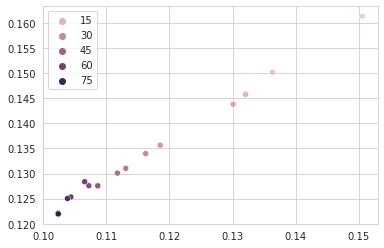

In [236]:
sns.scatterplot(x=kbest_rmsle_train, y=kbest_rmsle_test, hue=lassos.keys());

## Non-linear models

### Random Forest

In [ ]:
preprocess_cat_cols_2 = make_pipeline(
    SimpleImputer(
        missing_values = np.nan,
        strategy='constant',
        fill_value=MISSING),
    OrdinalEncoder(categories=categories)
)

preprocess_num_cols_2 = make_pipeline(
    SimpleImputer(
        missing_values=np.nan,
        strategy='median'
        ),
)

prepare_nonlinear = make_column_transformer(
    (preprocess_num_cols_2, num_cols),
    (preprocess_cat_cols_2, cat_cols),
    remainder='drop'
)

rf = make_pipeline(
    prepare_nonlinear,
    RandomForestRegressor(random_state=42)
)

rf_score = cross_validate(
    rf, X, y,
    scoring=['neg_mean_squared_error'],
    return_train_score=True,
)

In [ ]:
rf_ax = sns.scatterplot(
    x=np.sqrt(-rf_score['train_neg_mean_squared_error']),
    y=np.sqrt(-rf_score['test_neg_mean_squared_error']),
)
rf_ax.set(
    xlabel='train score',
    ylabel='test score',
)
plt.show()

### XGBoost

In [ ]:
xgb = make_pipeline(
    prepare_nonlinear,
    xgb.XGBRegressor()
)

xgb_score = cross_validate(
    xgb, X, y,
    scoring=['neg_mean_squared_error'],
    return_train_score=True,
)

In [ ]:
xgb_ax = sns.scatterplot(
    x=np.sqrt(-xgb_score['train_neg_mean_squared_error']),
    y=np.sqrt(-xgb_score['test_neg_mean_squared_error']),
)
xgb_ax.set(
    xlabel='train score',
    ylabel='test score',
)
plt.show()